# <a id = "top" > List of contents </a> 
# [Part 1](#1)
# [Part 2](#2)

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import random
import matplotlib.pyplot as plt
import matplotlib as mpl
from pandas_datareader import data as pdr
from sklearn.preprocessing import StandardScaler
import datetime as dt
import yfinance as yf
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
# Bagging -> Bootstrap Aggregation
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
#Step 3 fitting of algorithm
# Boosting -> Gradient Descent is an element of Gradient Boosting Regression - XGB & Random Forest
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
# Neural Network -> Multi-Level-Perceptron
from sklearn.neural_network import MLPRegressor
#Step 1 Fitting
from sklearn.model_selection import train_test_split
#Cross-validation
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
#Grid-search for Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV
#Step 4&5
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import chi2, f_regression
from sklearn.feature_selection import SelectKBest
import statsmodels.tsa.arima.model as stats
import statsmodels.api as sm
#EDA Tool Kits
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from statsmodels.graphics.tsaplots import plot_acf
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings("ignore")
# warnings.filterwarnings(action = "once")

In [2]:
data = yf.download("SPY", "2003-08-01", "2022-10-31")
data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2003-07-31,99.980003,100.910004,99.169998,99.389999,68.548241,54937200
2003-08-01,99.190002,99.529999,98.239998,98.510002,67.941307,49321000
2003-08-04,98.309998,99.000000,97.000000,98.510002,67.941307,55214100
2003-08-05,98.410004,98.760002,96.339996,96.419998,66.499817,61415600
2003-08-06,96.690002,98.059998,96.419998,96.980003,66.886078,50096900
...,...,...,...,...,...,...
2022-10-24,375.890015,380.059998,373.109985,378.869995,378.869995,85436900
2022-10-25,378.790009,385.250000,378.670013,384.920013,384.920013,78846300
2022-10-26,381.619995,387.579987,381.350006,382.019989,382.019989,104087300


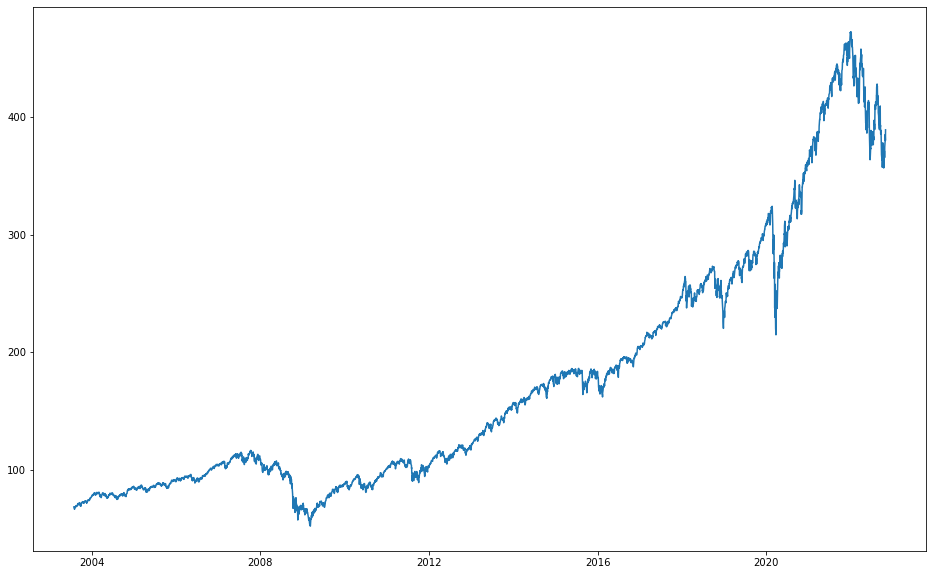

In [3]:
plt.figure(figsize = (16,10))
plt.plot(data["Adj Close"])

# <a id = "1" > Part 1 (Trading Strategies) </a> 
### [back to top](#top)

In [4]:
class trading_strategy():
    def __init__(self, df):
        self.df = df 
        self.returns = self.returns()
        
    def returns(self):
        self.df["returns"] = np.log(self.df["Adj Close"]/self.df["Adj Close"].shift(1))
        return self.df
        
    def MACD(self, short = 12, long = 26, m_signal = 9):
        self.df['ema_{}'.format(short)] = self.df["Adj Close"].ewm(span = short, adjust = False).mean()
        self.df['ema_{}'.format(long)] = self.df['Adj Close'].ewm(span = long, adjust = False).mean()
        self.df['macd'] = self.df['ema_{}'.format(short)] - self.df['ema_{}'.format(long)] 
        self.df['macd_signal'] = self.df['macd'].ewm(span = m_signal, adjust=False).mean()
        signal = []
        for i in range(len(self.df)):
            if self.df["macd"][i-1] < self.df["macd"][i] and self.df["macd"][i] > self.df["macd_signal"][i] \
            and self.df["macd"][i-1] < self.df["macd_signal"][i-1]:
                buy_signal = 1
                signal.append(buy_signal)
            elif self.df["macd"][i-1] > self.df["macd"][i] and self.df["macd"][i] < self.df["macd_signal"][i] \
            and self.df["macd"][i-1] > self.df["macd_signal"][i-1]:
                sell_signal = -1
                signal.append(sell_signal)
            else:
                holding_signal = 0 
                signal.append(holding_signal)
        self.df["position"] = (pd.DataFrame(signal, index = self.df.index)).diff()
        self.df["position"] = np.clip(self.df["position"], -1, 1) # to avoid extreme event that will give sudden signal change from 1 to -1.
        return self.df
    
    def RSI(self, period = 14, lower = 35, upper = 75):
        def rsi(df, period = 14):
            differences_in_price = self.df["Adj Close"].diff().dropna()
            u = differences_in_price * 0 # make all 0 
            d = u.copy() # copy variable u

            u[differences_in_price > 0] = differences_in_price[differences_in_price > 0] # assign this to u
            d[differences_in_price < 0] = -differences_in_price[differences_in_price < 0]

            u.iloc[period - 1] = np.mean(u[ :period]) # assigning the mean of first 14 days to the day 14 
            u = u.drop(u.index[ : (period -1)])
            d.iloc[period - 1] = np.mean(d[ :period])
            d = d.drop(d.index[ : (period -1)])

            rs = u.ewm(span = period - 1, adjust = False).mean() / d.ewm(com = period -1, adjust = False).mean()

            self.df["rsi"] = 100 - (100 / (1+rs))

            return self.df["rsi"]
        self.df["rsi"] = rsi(self.df)
        rsi_signal = []
        
        for i in range(len(self.df)):
            if self.df["rsi"][i-1] < lower and self.df["rsi"][i] >= lower:
                buy_signal = 1
                rsi_signal.append(buy_signal)
            elif self.df["rsi"][i-1] < upper and self.df["rsi"][i] >= upper:
                sell_signal = -1
                rsi_signal.append(sell_signal)
            else:
                holding_signal = 0
                rsi_signal.append(holding_signal)
        self.df["position"] = pd.DataFrame(rsi_signal, index = self.df.index).diff()
        return self.df
    
    def mean_reversion(self, window = 15):
        self.df["sma_{}".format(window)] = self.df["Adj Close"].rolling(window =window, center = True, min_periods =1).mean()
        self.df["moving_threshold"] = (self.df["Adj Close"].rolling(window = window, center = True, min_periods =1).std())
        self.df["upper_bound"] = self.df["sma_{}".format(window)] + self.df["moving_threshold"]
        self.df["lower_bound"] = self.df["sma_{}".format(window)] - self.df["moving_threshold"]
        
        self.signal = []

        for i in range(len(self.df)):
            if self.df["Adj Close"][i-1] > self.df["Adj Close"][i] and self.df["Adj Close"][i-1] > self.df["lower_bound"][i-1] \
            and self.df["Adj Close"][i] <= self.df["lower_bound"][i] :
                buy_signal = 1
                self.signal.append(buy_signal)
            elif self.df["Adj Close"][i-1] < self.df["Adj Close"][i] and self.df["Adj Close"][i-1] < self.df["upper_bound"][i-1] \
            and self.df["Adj Close"][i] >= self.df["upper_bound"][i] :
                sell_signal = -1
                self.signal.append(sell_signal)
            else:
                holding_period = 0 
                self.signal.append(holding_period)
                
        
        self.df["signal"] = pd.DataFrame(self.signal, index = self.df.index)
        self.df["prev_position"] = 0
        self.execution = []
        
        for x in range(len(self.df)):
            if self.df["signal"][x] == 1 and self.df["prev_position"][x] == 0:
                buy = 1
                self.df["prev_position"] = 1
                self.execution.append(buy)
            elif self.df["signal"][x] == -1 and self.df["prev_position"][x] == 1:
                sell = -1
                self.df["prev_position"] = 0
                self.execution.append(sell)
            elif self.df["signal"][x] == 1 and self.df["prev_position"][x] == 1:
                not_execute = 0
                self.execution.append(not_execute)
            else:
                hold = 0
                self.execution.append(hold)
        
        self.df["position"] = pd.DataFrame(self.execution, index = self.df.index).shift(1)
        
        return self.df

    
    def machine_learning(self, lags):
        cols = []
        for lag in range(1, lags +1):
            col = "lag_{}".format(lag)
            self.df[col] = self.df["returns"].shift(lag)
            cols.append(col)
            
        self.df = self.df.dropna()
    
        models = []
        models.append(("LR", LinearRegression()))
        models.append(("LASSO", Lasso()))
        models.append(("EN", ElasticNet()))
        models.append(("CART", DecisionTreeRegressor()))
        models.append(("KNN", KNeighborsRegressor()))
        models.append(("SVR", SVR()))
        models.append(("ETR", ExtraTreesRegressor()))
        models.append(("RFR", RandomForestRegressor()))
        models.append(("GBR", GradientBoostingRegressor()))
        models.append(("ABR", AdaBoostRegressor()))

        result = []
        names = []
        mae_all = []
        rmse_all = []

        self.df = self.df.dropna()
    
        for name ,model in models:
            names.append(name)
            model.fit(self.df[cols],self.df["returns"])
            self.df["prediction"] = model.predict(self.df[cols])
            self.df["position_{}".format(name)] = np.where(model.predict(self.df[cols]) > 0,1,-1)
            self.df["strategy_{}".format(name)] = self.df["position_{}".format(name)] * self.df["returns"]
            result.append(self.df["position_{}".format(name)])

        strategy_list = (self.df.columns[self.df.columns.str.startswith("strategy") == True]).to_list()

        for i in strategy_list:
            mae = abs(self.df["returns"] - self.df[i]).mean()
            rmse = np.sqrt(((self.df["returns"] - self.df[i])**2).mean())
            mae_all.append(mae)
            rmse_all.append(rmse)
            
        model_evaluation = pd.concat([pd.Series(names),pd.Series(mae_all), pd.Series(rmse_all)], axis = 1)
        model_evaluation.columns = ["model", "MAE", "RMSE"]
        
        display(model_evaluation.sort_values(by = "MAE")) # check model with low MAE and RMSE
        
        return self.df

In [5]:
data_1 = data.copy()
data_2 = data.copy()
data_3 = data.copy()
data_4 = data.copy()

In [6]:
new_data_1 = trading_strategy(data_1)
macd = new_data_1.MACD()
new_data_2 = trading_strategy(data_2)
rsi = new_data_2.RSI()
new_data_3 = trading_strategy(data_3)
mean_revert = new_data_3.mean_reversion()

In [7]:
new_data_4 = trading_strategy(data_4)
ml = new_data_4.machine_learning(3)

,model,MAE,RMSE
1,LASSO,0.000000,0.000000
2,EN,0.000000,0.000000
5,SVR,0.000132,0.005321
8,GBR,0.003016,0.013576
0,LR,0.005093,0.014065
3,CART,0.007302,0.017478
6,ETR,0.007302,0.017478
7,RFR,0.007308,0.017482
4,KNN,0.007359,0.017473
9,ABR,0.013801,0.021424


# <a id = "2" > Part 2 (comparing performance) </a>
### [back to top](#top)

In [8]:
class comparison(trading_strategy):
    def __init__(self, df):
        super().__init__(df)
        self.returns = trading_strategy(data).returns["returns"]
        self.strategy = self.strategy()
        self.cumulative_return = self.cumulative_return()
        self.max_cumulative_return = self.max_cumulative_return()
        self.drawdown = self.drawdown()
        self.sharpe_ratio = self.sharpe_ratio() 
        self.cagr = self.CAGR()
        self.drawdowns = self.drawdowns()
        self.final_amount = self.final_amount()
        
    def strategy(self):
        self.df["strategy"] = self.df["position"] * self.returns
        return self.df
    
    def cumulative_return(self):
        self.df["cumulative_return"] = self.df["strategy"].dropna().cumsum().apply(np.exp)
        return self.df
    
    def max_cumulative_return(self):
        self.df["max_cumulative_return"] = self.df["cumulative_return"].cummax()
        return self.df
    
    def drawdown(self):
        self.df["drawdown"] = self.df["max_cumulative_return"] - self.df["cumulative_return"]
        return self.df
    
    def sharpe_ratio(self):
        sharpe_ratio = (self.df["strategy"].mean()/self.df["strategy"].std()) * 252**0.5
        return sharpe_ratio
    
    def CAGR(self):
        duration = (self.df.index[-1] - self.df.index[0]).days
        cagr = (self.df["strategy"].dropna().cumsum().apply(np.exp)[-1]/ \
        self.df["strategy"].dropna().cumsum().apply(np.exp)[0]) ** (365/duration) -1
        return cagr
    
    def drawdowns(self):
        index = self.df[self.df['drawdown'] == 0].index
        drawdown_detail = []
        for i in range(1,len(index)):  
            period = index[i].to_pydatetime() - index[i-1].to_pydatetime()  
            max_drawdown = self.df.loc[index[i-1]:index[i],'drawdown'].max()  
            drawdown_detail.append([period,max_drawdown,index[i-1],index[i]]) 
        drawdown = pd.DataFrame(drawdown_detail,columns=['period','max_drawdown','beginning','end']).sort_values('max_drawdown',ascending=False)  
        return drawdown.head(1)
    
    def final_amount(self):
        capital = 500000
        final_amount = self.df["cumulative_return"][-1] * capital
        return final_amount
    
    def numerical_evidence(self):
        evidence = []
        evidence.append([self.sharpe_ratio,self.cagr,self.drawdowns.iloc[0,1],\
                         self.drawdowns.iloc[0,0],self.final_amount, self.cumulative_return["cumulative_return"][-1]])
        numerical_df = pd.DataFrame(evidence)
        return numerical_df

In [9]:
spy = data.copy()
spy["position"] = 1

In [10]:
ml_svr = ml[["Adj Close","position_SVR"]]
ml_svr.columns =  ["Adj Close", "position"]
ml_lasso = ml[["Adj Close","position_LASSO"]]
ml_lasso.columns =  ["Adj Close", "position"]
ml_GBR = ml[["Adj Close","position_GBR"]]
ml_GBR.columns =  ["Adj Close", "position"]
ml_lr = ml[["Adj Close","position_LR"]]
ml_lr.columns =  ["Adj Close", "position"]

In [11]:
comparison_df = pd.concat([comparison(spy).numerical_evidence(),comparison(macd).numerical_evidence(),comparison(rsi).numerical_evidence(),\
                          comparison(mean_revert).numerical_evidence(),comparison(ml_lasso).numerical_evidence(), comparison(ml_svr).numerical_evidence() \
                          ,comparison(ml_GBR).numerical_evidence(), comparison(ml_lr).numerical_evidence()])

In [12]:
comparison_df.columns = ["sharpe_ratio", "CAGR", "max_drawdown", "max_drawdown_duration", "final_amount", "cumulative_returns"]
comparison_df.index = ["SPY","MACD","RSI","Mean_reversion","ML_Lasso","ML_SVR","ML_GBR", "ML_LR"]

In [13]:
comparison_df.sort_values(by = "cumulative_returns", ascending = False)

,sharpe_ratio,CAGR,max_drawdown,max_drawdown_duration,final_amount,cumulative_returns
ML_GBR,2.686981,0.657355,1028.644273,84 days,8.380749e+09,16761.498651
RSI,1.518330,0.149294,0.430731,185 days,7.289995e+06,14.579990
MACD,1.951248,0.147634,0.463495,89 days,7.089799e+06,14.179598
ML_SVR,0.656047,0.132895,1.135892,26 days,5.548174e+06,11.096348
Mean_reversion,2.003217,0.118870,0.179946,84 days,4.348592e+06,8.697183
ML_LR,0.580153,0.116643,1.117648,700 days,4.201567e+06,8.403134
ML_Lasso,0.481342,0.095821,1.642856,173 days,2.924970e+06,5.849941
SPY,0.472739,0.094845,1.593762,173 days,2.837564e+06,5.675127


Text(0.5, 1.0, 'SPY')

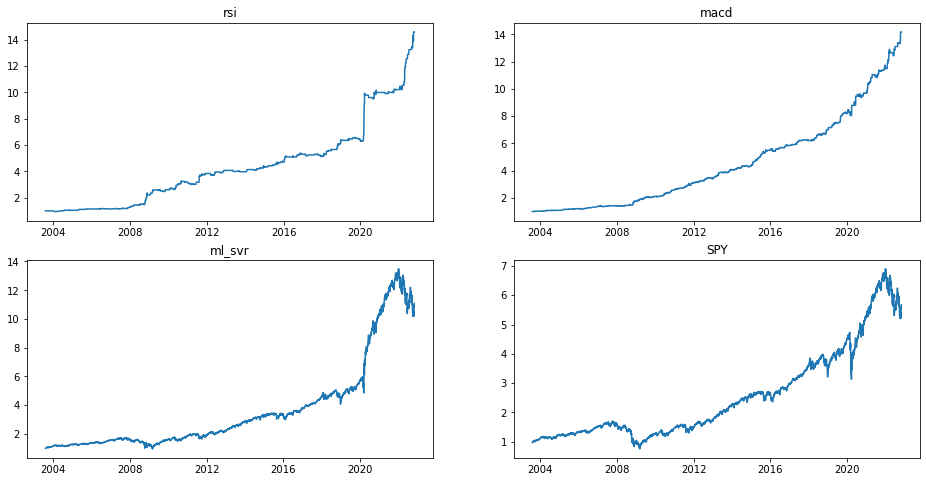

In [14]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(16, 8))
axs[0,1].plot(macd["cumulative_return"])
axs[0,1].set_title("macd")

axs[0,0].plot(rsi["cumulative_return"])
axs[0,0].set_title("rsi")

axs[1,0].plot(ml_svr["cumulative_return"])
axs[1,0].set_title("ml_svr")

axs[1,1].plot(spy["cumulative_return"])
axs[1,1].set_title("SPY")

Text(0.5, 1.0, 'SPY')

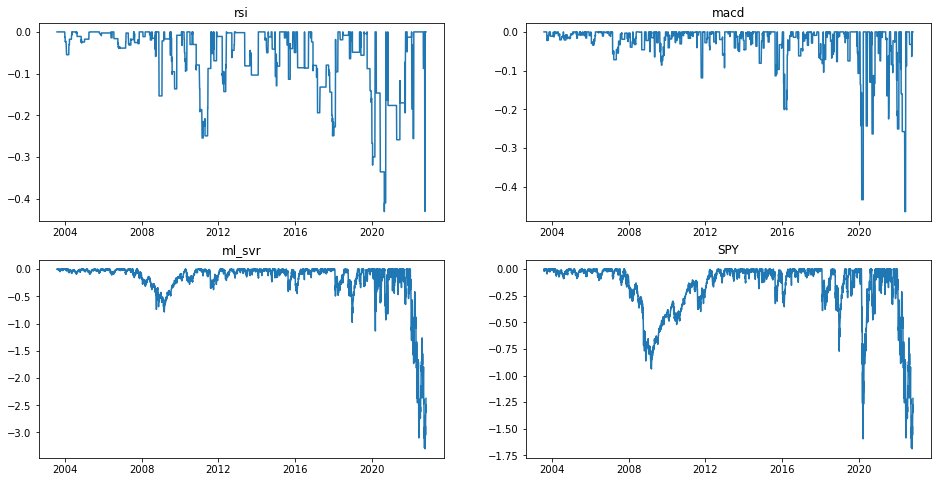

In [18]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(16, 8))
axs[0,1].plot(-macd["drawdown"])
axs[0,1].set_title("macd")

axs[0,0].plot(-rsi["drawdown"])
axs[0,0].set_title("rsi")

axs[1,0].plot(-ml_svr["drawdown"])
axs[1,0].set_title("ml_svr")

axs[1,1].plot(-spy["drawdown"])
axs[1,1].set_title("SPY")